## MSBA Portfolio Risk, Optimization, and Scenario Analysis

#### Below is an implentation of a Risk index to more easily understand and conceptualize the risk profile offered by financial metrics. Additionally Portfolio Optimization with regard to finding the most optimal weights is calculated. Finally a simple scenario analysis is conducted to highlight portfolio performance during different market conditions.

#### pip installations

In [1]:
#!pip3.12 install yahooquery
#!pip3.12 install pandas
#!pip3.12 install numpy
#!pip3.12 install matplotlib
#!pip3.12 install seaborn
#!pip3.12 install yfinance
#!pip3.12 install requests
#!pip3.12 install datetime
#!pip3.12 install scipy
#pip 3,12 install transformers


### Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from newsapi import NewsApiClient
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### API's Used: Yahoo Finance and FRED (Federal Reserve Economic Data)

#### Links to obtain keys:
https://newsapi.org/

https://fred.stlouisfed.org/docs/api/fred/

### API KEYS HERE

In [3]:
#API's
fred=Fred(api_key='')#### ENTER YOUR API KEY HERE
newsapi = NewsApiClient(api_key='') #### ENTER YOUR API KEY HERE



### Loading Portfolio Data From Google Sheets

In [4]:
url='https://docs.google.com/spreadsheets/d/1URFk8rIxM74hHgZA6IGF9kspG6r3eEeLDOi-lzaYaaE/edit#gid=0'
sheet_id=url.split('/')[-2]
goog_sheets_df=pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv',skiprows=3)


#Creating lists and dictionarires for later for loop iterations
symbols_lst = goog_sheets_df['Symbol'].tolist()
sector_lst = goog_sheets_df['Sector'].tolist()

symbols_sectors_dict = dict(zip(symbols_lst, sector_lst))

symbols_lst = [symbol.strip() for symbol in symbols_lst]
sector_lst = [sector.strip() for sector in sector_lst]


### Gathering Risk Free Rate - Shown in 2 different ways

In [5]:
#Gathering Risk Free Rate - Used in Sharpe Ratio

irx= yf.Ticker("^IRX")
rf=(irx.history(period="1d").Close.iloc[-1])/100
rf


0.052179999351501465

### From Fred Api 1 Year TBond - prefered method

##### Note if 2 year, 1 year, or 5 year TBond rates are preffered us the following series: DGS2, WGS1YR, DGS5

In [6]:
#from Fred 
rf=fred.get_series('DGS1')[-1]/100
rf


0.049800000000000004

### Gathering and Computing Risk Metrics
Analysis uses 1 year of data, log returns, and BlackRocks method of calculating VAR. Feel free to adjust these parameters as you see fit.

In [7]:
portfolio_metrics = pd.DataFrame(columns=['Ticker',
                                          'Name',
                                          'Sector', 
                                          'Beta', 
                                          'Volatility', 
                                          'Liquidity Ratio',
                                          'Short Ratio',
                                          'Debt to Equity Ratio',
                                          'Current Ratio',
                                          'Quick Ratio',
                                          'Sharpe Ratio',
                                          'Yearly VAR %',
                                          'Price to Book Ratio',
                                          'Portfolio Weight %'
                                          ])


for ticker,sector in symbols_sectors_dict.items():

        stock = yf.Ticker(ticker)
        stock_hist = stock.history(period="1y")
        
        
        #latest balance sheet and income statement dates- used in error cases
        latest_bs_date=stock.balance_sheet.columns.max()
        latest_is_date=stock.income_stmt.columns.max()     
        
        stock_name=stock.info.get('shortName', np.nan)

        
        
        # Retrieve the required information
        
        beta = stock.info.get('beta', np.nan)

        
        volatility = stock.history(period="1y")['Close'].pct_change().std() * math.sqrt(252)
        
        # Liquidity
        liquidity = stock.info.get('sharesOutstanding', np.nan) / stock.info.get('averageDailyVolume10Day', np.nan)
    
        # Short ratio
        short_ratio = stock.info.get('shortRatio', np.nan)
    
        # Debt to equity 

        debt_to_equity = stock.info.get('debtToEquity', np.nan) 
        debt_to_equity=debt_to_equity/100
    
   
        # Current ratio
        current_ratio = stock.info.get('currentRatio', np.nan)
    
        # Quick ratio
        quick_ratio = stock.info.get('quickRatio', np.nan)
     
        
        # Sharpe ratio
        annualized_return = stock_hist['Close'].iloc[-1] / stock_hist['Close'].iloc[0] - 1
        daily_returns_time_series = stock.history(period="1y").Close.shift(-1) / stock.history(period="1y").Close - 1 #calculating daily returns for the year
        annualized_stdev = daily_returns_time_series.std() * math.sqrt(252)
        sharpe_ratio = (annualized_return - rf) / annualized_stdev
        
        #calculating yearly VAR
        yearly_returns_time_series = ((stock.history(period="1y").Close.shift(-1) / stock.history(period="1y").Close - 1)*100).dropna()
        var_84 = np.percentile(yearly_returns_time_series, 16)*np.sqrt(252) #calculating var based on 1 year of data and 84 confidence - From BlackRock
        
        
        #price to book ratio
        pb_ratio=stock.info.get('priceToBook', np.nan)
                
        #weights
        weights= goog_sheets_df.loc[goog_sheets_df['Symbol']==ticker]['Portfolio Weights'].values[0]
         
        
        
        
        
        
        
        
        

        # Append the information to the portfolio_metrics DataFrame
        stock_metrics = pd.DataFrame({'Ticker': ticker,
                                      'Name': stock_name,
                                        'Sector': sector,
                                        'Beta': beta,
                                        'Volatility': volatility,
                                        'Liquidity Ratio': liquidity,
                                        'Short Ratio': short_ratio,
                                        'Debt to Equity Ratio': debt_to_equity,
                                        'Current Ratio': current_ratio,
                                        'Quick Ratio': quick_ratio,
                                        'Sharpe Ratio': sharpe_ratio,
                                        'Yearly VAR %': var_84,
                                        'Price to Book Ratio': pb_ratio,
                                        'Portfolio Weight %': weights
                                        }, index=[0])
        portfolio_metrics = pd.concat([portfolio_metrics, stock_metrics], ignore_index=True)




# Manually Cleaning Null Values

### Debt To Equity

In [8]:
#fixing debt to equity ratio

for index, row in portfolio_metrics.iterrows():
    # Retrieve the debt to equity ratio value from the current row
    debt_to_equity_ratio = row['Debt to Equity Ratio']
    
    # Check if the value is missing (NaN)
    if np.isnan(debt_to_equity_ratio):
        try:
            # Retrieve ticker symbol from the current row
            ticker_symbol = row['Ticker']
            
            # Pull balance sheet data using yfinance
            ticker = yf.Ticker(ticker_symbol)
            balance_sheet = ticker.balance_sheet
            
            # Calculate the debt to equity ratio using the latest balance sheet data
            latest_bs_date = balance_sheet.columns.max()
            
            
            total_liabilities = balance_sheet[latest_bs_date].loc['Total Liabilities Net Minority Interest']
            stockholders_equity = balance_sheet[latest_bs_date].loc['Stockholders Equity']
            # Update the 'Debt to Equity Ratio' column with the calculated value
            portfolio_metrics.at[index, 'Debt to Equity Ratio'] = total_liabilities / stockholders_equity
        except Exception as e:
            print(f"Error calculating debt to equity ratio for index {index} and ticker {ticker_symbol}: {e}")



### Current Ratio

In [9]:
#fixing current ratio
for index, row in portfolio_metrics.iterrows():
    # Retrieve the debt to equity ratio value from the current row
    current_ratio = row['Current Ratio']
    
    # Check if the value is missing (NaN)
    if np.isnan(current_ratio):
        try:
            # Retrieve ticker symbol from the current row
            ticker_symbol = row['Ticker']
            
            
            ticker = yf.Ticker(ticker_symbol)
            balance_sheet = ticker.balance_sheet
            
            
            latest_bs_date = balance_sheet.columns.max()
            
            
            current_assets = balance_sheet[latest_bs_date].loc['Current Assets'] #bac has no current assets or liabilities
            current_liabilities = balance_sheet[latest_bs_date].loc['Current Liabilities']
            
            portfolio_metrics.at[index, 'Current Ratio'] = current_assets / current_liabilities
        except Exception as e:
            print(f"Error calculating current ratio for index {index} and ticker {ticker_symbol}: {e}")

Error calculating current ratio for index 10 and ticker JPM: 'Current Assets'
Error calculating current ratio for index 11 and ticker BAC: 'Current Assets'
Error calculating current ratio for index 12 and ticker WFC: 'Current Assets'


In [10]:
#fixing price to book ratio
for index, row in portfolio_metrics.iterrows():
    # Retrieve the debt to equity ratio value from the current row
    price_to_book = row['Price to Book Ratio']
    
    # Check if the value is missing (NaN)
    if np.isnan(price_to_book):
        try:
            # Retrieve ticker symbol from the current row
            ticker_symbol = row['Ticker']
            
            
            ticker = yf.Ticker(ticker_symbol)
            balance_sheet = ticker.balance_sheet
            
            
            latest_bs_date = balance_sheet.columns.max()
            
            #gathering price to book calculating data
            #price to book ratio = market price per share/book value per share
            
            #market price per share = last traded stock price
            #book value per share = stockholders equity / shares outstanding
            
            #last closing price
            market_price_per_share = ticker.history(period="1d").Close.iloc[-1]
            book_value_per_share = balance_sheet[latest_bs_date].loc['Stockholders Equity'] / ticker.info.get('sharesOutstanding', np.nan)
            
            
            
            
            

            
            portfolio_metrics.at[index, 'Price to Book Ratio'] = market_price_per_share / book_value_per_share
        except Exception as e:
            print(f"Error calculating price to book ratio for index {index} and ticker {ticker_symbol}: {e}")

### Risk Index - Sentiment Analysis

#### Built into the Risk index is a sentiment analysis. This sentiment analysis uses Hugging Face's Sigma Financial Sentiment Analysis Model to score a news article description or title for each holding provided. The scores are orignially provided in a possitive, nuetral, and negative format, but I decided to compute a compound score to represent the three score for easier interpretation. My compounded score ranges from 1 to 100, where 1 represents the worst sounding news, 100 represents the best sounding news, and 50 represents nuetral news.

### Downloading the Model from Hugging Face

In [11]:
MODEL = f"Sigma/financial-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [12]:
''' Calculate the compound polarity score for a given text using the Signma Financial model.'''

def compound_polarity_scores(example):
    if pd.isnull(example):
        return example  # Return NaN if the value is NaN
    else:
    # model boilerplate code
        encoded_text = tokenizer(example, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        scores_dict = {
            'financial_neg' : scores[0],
            'finacial_neu' : scores[1],
            'finacial_pos' : scores[2]
        }
        
        
        sentiment_probabilities = np.array([scores_dict['financial_neg'], scores_dict['finacial_neu'], scores_dict['finacial_pos']])
        
        
        
        
        sentiment_weights = np.array([-1, 0, 1])
        compound_score = sentiment_probabilities.dot(sentiment_weights)
        return compound_score
        
    


### The Scoring Process: 
##### The scores range from 1 to 100 where the lower score, the better sounding the news. This to ensure these 'normalized values' work in conjunction with the risk scores scoring logic later on. 

In [13]:
'''Convert a sentiment score to a transformed score between 1 and 100.'''
def transform_sentiment_score(sentiment_score):
    return 100 - 49.5 * (sentiment_score + 1)


### Pulling News Data from Yahoo Finance for each of our holdings

In [14]:

# Initialize an empty DataFrame to store all the data
yf_news_data = pd.DataFrame()

for i in symbols_lst:
    # Yahoo Finance news logic
    ticker_yf_data = yf.Ticker(i)
    ticker_yf_news = ticker_yf_data.news
    yf_news_lst = [article['title'] for article in ticker_yf_news]
    
    # Pad shorter lists with NaN values to match the length of the DataFrame's index
    padded_news_lst = yf_news_lst + [float('nan')] * (len(yf_news_data.index) - len(yf_news_lst))
    
    # Add the news data as a column to the DataFrame with the ticker as the column name
    yf_news_data[i] = padded_news_lst

yf_news_data


,MSFT,META,GOOGL,AMZN,NVDA,JNJ,PFE,MRK,ABT,UNH,...,PG,KO,PEP,WMT,COST,XOM,CVX,COP,SLB,BP
0,Is MSFT Stock A Buy Now? What The Fundamentals...,"Dow Jones Futures Rise: Fed Chief Powell, CPI ...",Microsoft to offer Apple devices to employees ...,Will Walmart Be a Trillion-Dollar Stock by 203...,"Commercial real estate, Good Buy or Goodbye: M...",Long-Term Dividend Growth And Recent Hikes: Jo...,Pfizer (PFE) Stock Slides as Market Rises: Fac...,Roche's New Immunotherapy Fails To Show Benefi...,"DexCom (DXCM), Abbott to Launch First FDA Clea...",Invest with Confidence: Intrinsic Value Unveil...,...,Procter & Gamble (PG) Laps the Stock Market: H...,Coca-Cola (KO) Stock Slides as Market Rises: F...,"PepsiCo's Second-Quarter Snacks, Beverage Volu...",Will Walmart Be a Trillion-Dollar Stock by 203...,The Best Costco Finds This Week,Exxon Mobil (XOM) Stock Sinks As Market Gains:...,Venezuela Inflation Slows to 12-Year Low as Ma...,Raymond James Adjusts Price Target on ConocoPh...,Schlumberger OneSubsea JV Awarded TotalEnergie...,BP p.l.c. (BP): Why are Hedge Funds Bullish on...
1,Why Did IonQ Stock Tumble 14% in June?,Meta Platforms (META) Stock Sinks As Market Ga...,Top Wall Street strategist explains why he's a...,Why Is Amazon Investing in Saks + Neiman’s?,Why Nvidia Stock Climbed Last Month and Has Ke...,Johnson & Johnson: An Exploration into Its Int...,Pfizer's RSV Vaccine Abrysvo Clears Concerns O...,Merck (NYSE:MRK) Seems To Use Debt Quite Sensibly,Is Abbott Laboratories (ABT) a Good Dividend G...,Insurers Pocketed $50 Billion From Medicare fo...,...,Brokers Suggest Investing in P&G (PG): Read Th...,3 Warren Buffett Stocks to Buy Hand Over Fist,PepsiCo Faces Tough Choice Between Earnings Ta...,Ride Bullish Momentum with These 3 Buy Rated S...,4 Great Reasons for New Parents to Get a Costc...,"Commercial real estate, Good Buy or Goodbye: M...",I Have High Hopes for These 3 Dirt Cheap Divid...,ConocoPhillips (COP) Challenges Biden's Arctic...,SLB OneSubsea Awarded Contract for TotalEnergi...,Shell and BP Among Big Firms Taking Stakes in ...
2,Microsoft to offer Apple devices to employees ...,"As Nvidia Rises, Two Mag 7 Stocks Remain In Bu...",Analysts reboot Google parent stock price targ...,How an ‘accident’ helped the creators of the M...,Super Micro Computer Stock Surges as AI-Relate...,J&J (JNJ) Trades Below 200 & 50-Day Moving Ave...,Here's Why Sarepta (SRPT) Stock Price Surged 5...,mRNA Technology Promises To Make A Long-Time C...,Evercore ISI Adjusts Price Target on Abbott La...,Why the Walmart Model Doesn’t Work in Healthcare,...,Trump is keen to lower corporate taxes. Not al...,Meet the Stock Generating More Than $1 Billion...,Update: BofA Securities Cuts Price Target on P...,Walmart Inc. (WMT) Is a Trending Stock: Facts ...,Here's Why Costco (COST) is a Strong Growth Stock,Exxon expects Q2 earnings to take a hit from r...,Chevron (CVX) Furloughs Biodiesel Workers Amid...,ConocoPhillips challenges Alaska drilling rest...,"Schlumberger, ChampionX Receive DOJ 2nd Reques...",BP (LON:BP.) Might Have The Makings Of A Multi...
3,Top Wall Street strategist explains why he's a...,"Meta’s Top Line Will Rise Strongly, Say Ad-Spe...",Phoenix cop pulls over errant Waymo self-drivi...,"As Nvidia Rises, Two Mag 7 Stocks Remain In Bu...",Why Did IonQ Stock Tumble 14% in June?,3 High-Yield Dividend Stocks/ETFs to Buy Hand ...,UK pharma group reprimands Novo Nordisk for un...,N-Power Medicine partners with MSD to expand a...,3 MedTech Stocks to Buy for Healthy Gains,The Dow Is Dipping. Blame UnitedHealth Stock.,...,"Coca-Cola Is a Rock-Solid Dow Dividend Stock, ...","Coca-Cola Is a Rock-Solid Dow Dividend Stock, ...",Pre-Q2 Earnings Review: To Buy or Not to Buy P...,New to Investing? This 1 Retail and Wholesale ...,BURL or COST: Which Is the Better Value Stock ...,Sector Update: Energy Stocks Decline in Monday...,"Fed’s Powell, Inflation Data, Earnings Can Cem...",ConocoPhillips Sues Interior Department Over R...,SLB Provides Update on Pla

### Below I set up a debug code block becuase the News API required a alot of testing when it came to queries. You may find with some stocks you may need to adjust the querrey or construct new ones for certain stocks. It is therefore helpfull to only test a few stocks at a time in order to speed up run time and cut down on API requests to avoid rate limit errors. To debug, set the debug = True

In [15]:
#Getting last week to get news for the last week
today = datetime.date.today()
last_week = today - datetime.timedelta(days=7)

In [16]:
#setting up debug for testing purposes due to 100 API request limit

debug = False
if debug:
    # Pull the first 5 keys from the dictionary
    keys = list(symbols_sectors_dict.keys())[2:5]
    debug_symbols_sectors_dict = {key: symbols_sectors_dict[key] for key in keys}
    
    
else:
    # Pull everything from the dictionary
    debug_symbols_sectors_dict = symbols_sectors_dict

### News API Data
#### To get more news data I am using News API (https://newsapi.org/). I am making queries and sending those querires via API requests to get last weeks news data for each stock within the portfolio.

#### The data that I am getting consists of news article descriptions- where there ussually is a paragraph of content summarizing the article. If a description cannot be found then the title is located instead.

In [17]:

news_api_df = pd.DataFrame()

for nticker in debug_symbols_sectors_dict.keys():
    try:           
            #querey to retreive data from newsapi
            query = f'Financial AND {nticker}'
            language = 'en'
            articles = newsapi.get_everything(q=query, language=language, sort_by='relevancy',from_param=last_week)
            article_df = pd.DataFrame(articles['articles'])

            # Filter articles based on whether title contains the nticker symbol
            article_df = article_df[
                article_df['title'].str.contains(nticker, case=False, na=False) &
                article_df['description'].str.contains(nticker, case=False, na=False)
            ].reset_index(drop=True)

            # Assign the DataFrame to the MultiIndex DataFrame
            news_api_df[(nticker)] = article_df['description'].fillna(article_df['title'])

    except KeyError as e:
        # Handle KeyError (e.g., no articles found) gracefully
        print(f"No articles found for {nticker}. Skipping...")
        continue

##### News API df consists of descriptions or titles for each of the holdings.

In [18]:
news_api_df

,MSFT,META,GOOGL,AMZN,NVDA,JNJ,PFE,MRK,ABT,UNH,...,PG,KO,PEP,WMT,COST,XOM,CVX,COP,SLB,BP
0,Horizon Financial Services LLC purchased a new...,"Let's talk about the popular Meta Platforms, I...",Quattro Financial Advisors LLC increased its s...,OneAscent Financial Services LLC decreased its...,NVIDIA Co. (NASDAQ:NVDA – Get Free Report) CEO...,TFC Financial Management Inc. cut its stake in...,Marshall Financial Group LLC lowered its stake...,BOK Financial Private Wealth Inc. increased it...,Redmont Wealth Advisors LLC purchased a new st...,New Century Financial Group LLC trimmed its ho...,...,Whelan Financial lifted its position in The Pr...,Marshall Financial Group LLC raised its holdin...,Nvest Financial LLC raised its position in sha...,Narus Financial Partners LLC raised its holdin...,We break down the steps Kevin Costner needs to...,Dean Jacobson Financial Services LLC lessened ...,Teamwork Financial Advisors LLC decreased its ...,There are quite a few similar movies to watch ...,HOUSTON — Regulatory News: SLB (NYSE: SLB) tod...,NaN
1,Sunburst Financial Group LLC decreased its pos...,Brazil’s data protection authority temporarily...,Narus Financial Partners LLC trimmed its posit...,Howard Financial Services LTD. lifted its stak...,NVIDIA Co. (NASDAQ:NVDA – Get Free Report) CEO...,RTD Financial Advisors Inc. lowered its holdin...,Valley National Advisers Inc. grew its stake i...,Financial Sense Advisors Inc. decreased its po...,Hexagon Capital Partners LLC lowered its stake...,Valeo Financial Advisors LLC boosted its posit...,...,Allspring Global Investments Holdings LLC boos...,Teamwork Financial Advisors LLC decreased its ...,True Link Financial Advisors LLC acquired a ne...,Colton Groome Financial Advisors LLC grew its ...,Chase Bank's Marianne Lake warns customers abo...,Whelan Financial acquired a new stake in Exxon...,Talbot Financial LLC lifted its holdings in sh...,Miracle Mile Advisors LLC grew its stake in Co...,Teamwork Financial Advisors LLC lessened its h...,NaN
2,Norwood Financial Corp reduced its position in...,"Nvidia, Microsoft, Meta Warn Investors That AI...",OneAscent Financial Services LLC cut its posit...,WoodTrust Financial Corp reduced its stake in ...,NVIDIA Co. (NASDAQ:NVDA – Get Free Report)’s s...,Financial Sense Advisors Inc. cut its holdings...,Saxon Interests Inc. trimmed its holdings in s...,Benchmark Financial Wealth Advisors LLC booste...,Plimoth Trust Co. LLC reduced its position in ...,Albion Financial Group UT decreased its holdin...,...,Financial Security Advisor Inc. decreased its ...,Azzad Asset Management Inc. ADV decreased its ...,Talbot Financial LLC raised its position in sh...,Financial Perspectives Inc raised its position...,"With cost of living issues still at large, two...",Pettinga Financial Advisors LLC reduced its st...,Valeo Financial Advisors LLC lifted its holdin...,Janney Montgomery Scott LLC raised its positio...,Sumitomo Mitsui Trust Holdings Inc. reduced it...,NaN
3,Sovereign Financial Group Inc. raised its hold...,New Century Financial Group LLC raised its hol...,Symphony Financial Ltd. Co. cut its holdings i...,Monumental Financial Group Inc. acquired a new...,Shares of NVIDIA Co. (NASDAQ:NVDA – Get Free R...,Valeo Financial Advisors LLC lowered its posit...,Advisor Resource Council lessened its holdings...,LVW Advisors LLC lifted its position in Merck ...,SeaCrest Wealth Management LLC reduced its sta...,Leeward Financial Partners LLC lifted its hold...,...,Colton Groome Financial Advisors LLC cut its h...,Plimoth Trust Co. LLC boosted its holdings in ...,Teamwork Financial Advisors LLC trimmed its st...,Annapolis Financial Services LLC raised its po...,NaN,Morris Financial Concepts Inc. grew its holdin...,Tributary Capital Management LLC acquired a ne...,Norden Group LLC grew its holdings in ConocoPh...,J.W. Cole Advisors Inc. grew its position in S...,NaN
4,JNBA Financial Advisors lowered its position i...,Morris Financial Concepts Inc. lowered its sta...,Financial

In [19]:
#combine the two dataframes
combined_df = pd.concat([news_api_df,yf_news_data], axis=0)

### Model Applying Scores

In [20]:
#perform sentiment analysis on the combined_df with huggingface sentiment model
sentiment_scores=combined_df.applymap(compound_polarity_scores)

### Sentiment Scores

In [21]:
transformed_scores=sentiment_scores.applymap(transform_sentiment_score)

average_sentiment_scores = transformed_scores.mean(axis=0)
number_of_scores = sentiment_scores.count()

In [22]:
#note the range is -1 to 1 for the score
sentiment_scores_df=pd.DataFrame({'Weekly Average Sentiment Scores': average_sentiment_scores, 'Number of scores': number_of_scores})



for stock in sentiment_scores_df.index:
    stock_data = yf.Ticker(stock)
    stock_df = stock_data.history(period='1mo', start=last_week, end=today)
    sentiment_scores_df.loc[stock, f'{last_week} Stock Price'] = stock_df['Close'].iloc[0]
    sentiment_scores_df.loc[stock, f'{today} Stock Price'] = stock_df['Close'].iloc[-1]



# calculating the percentage change in stock price
sentiment_scores_df['Stock Price Weekly Percentage Change (%)'] = ((sentiment_scores_df[f'{today} Stock Price'] - sentiment_scores_df[f'{last_week} Stock Price']) / sentiment_scores_df[f'{last_week} Stock Price']) * 100

### Sentiment Score's Dataframe

In [23]:
sentiment_scores_df


,Weekly Average Sentiment Scores,Number of scores,2024-07-02 Stock Price,2024-07-09 Stock Price,Stock Price Weekly Percentage Change (%)
MSFT,65.473944,69,459.279999,466.239990,1.515414
META,41.202524,40,509.500000,529.320007,3.890090
GOOGL,49.067779,50,185.240005,189.029999,2.045991
AMZN,58.293237,56,200.000000,199.289993,-0.355003
NVDA,65.279751,14,122.669998,128.199997,4.508029
JNJ,55.617921,55,146.029999,145.479996,-0.376637
PFE,57.061745,17,27.830000,27.930000,0.359326
MRK,46.602981,60,127.720001,125.779999,-1.518950
ABT,65.261824,13,103.199997,102.120003,-1.046506
UNH,44.893481,40,498.239990,489.339996,-1.786287


### Benchmark Data - Necessary for the normalization process

### Gathering Benchmark data is used by using the Yahoo Screener to bulk download stock data by *sector*

In [24]:
#from the screeners - we have the following sectors

available_sectors= ['ms_basic_materials',
 'ms_communication_services',
 'ms_consumer_cyclical',
 'ms_consumer_defensive',
 'ms_energy',
 'ms_financial_services',
 'ms_healthcare',
 'ms_industrials',
 'ms_real_estate',
 'ms_technology',
 'ms_utilities']

In [25]:
#gathering benchmark data from yahooquery
from yahooquery import Screener
s = Screener()
# Dictionary to store data for each sector
sector_data = {}
dfs = []

# Retrieve the data for each sector
for sector in available_sectors:
    data = s.get_screeners(sector, count=150)
    quotes = data[sector]['quotes']
    sector_data[sector] = quotes
    # Create a DataFrame for the current sector
    df = pd.DataFrame(quotes)
    # Add a column for the sector
    df['sector'] = sector
    # Append the DataFrame 
    dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
benchmark_data = pd.concat(dfs, ignore_index=True)

new_benchmark_lst=benchmark_data['symbol'].tolist()

In [26]:
#calculating the metrics for the benchmark data - same as before

# Initialize an empty dataframe to store the metrics
benchmark_metrics = pd.DataFrame(columns=['Ticker',
                                          'Name',
                                          'Sector', 
                                          'Beta', 
                                          'Volatility', 
                                          'Liquidity Ratio',
                                          'Short Ratio',
                                          'Debt to Equity Ratio',
                                          'Current Ratio',
                                          'Quick Ratio',
                                          'Sharpe Ratio',
                                          'Yearly VAR %',
                                          'Price to Book Ratio'
                                          ])

# Iterate through each ticker and sector in the dictionary
for symbol1 in new_benchmark_lst:

    try:
        # Fetch stock data
        stock = yf.Ticker(symbol1)
        stock_hist = stock.history(period="1y")
        
        # Retrieve stock name
        stock_name = stock.info.get('shortName', np.nan)
        
        # Retrieve sector
        b_sector = stock.info.get('sector', np.nan)

        # Retrieve the required financial metrics
        beta = stock.info.get('beta', np.nan)

        # Calculate volatility
        volatility = stock.history(period="1y")['Close'].pct_change().std()*math.sqrt(252)

        # Calculate liquidity ratio
        liquidity = stock.info.get('sharesOutstanding', np.nan) / stock.info.get('averageDailyVolume10Day', np.nan)

        # Retrieve short ratio
        short_ratio = stock.info.get('shortRatio', np.nan)

        # Retrieve debt to equity ratio
        debt_to_equity = stock.info.get('debtToEquity', np.nan) / 100

        # Retrieve current ratio
        current_ratio = stock.info.get('currentRatio', np.nan)

        # Retrieve quick ratio
        quick_ratio = stock.info.get('quickRatio', np.nan)

        # Calculate Sharpe ratio
        annualized_return = stock_hist['Close'].iloc[-1] / stock_hist['Close'].iloc[0] - 1
        daily_returns_time_series = stock.history(period="1y").Close.shift(-1) / stock.history(period="1y").Close - 1
        annualized_stdev = daily_returns_time_series.std() * math.sqrt(252)
        sharpe_ratio = (annualized_return - rf) / annualized_stdev

        # Calculate yearly VAR
        yearly_returns_time_series = ((stock.history(period="1y").Close.shift(-1) / stock.history(period="1y").Close - 1) * 100).dropna()
        var_84 = np.percentile(yearly_returns_time_series, 16)*np.sqrt(252)

        # Retrieve price to book ratio
        price_to_book = stock.info.get('priceToBook', np.nan)

        # Append the information to the benchmark_metrics DataFrame
        stock_metrics = pd.DataFrame({'Ticker': symbol1,
                                      'Name': stock_name,
                                      'Sector': b_sector,
                                      'Beta': beta,
                                      'Volatility': volatility,
                                      'Liquidity Ratio': liquidity,
                                      'Short Ratio': short_ratio,
                                      'Debt to Equity Ratio': debt_to_equity,
                                      'Current Ratio': current_ratio,
                                      'Quick Ratio': quick_ratio,
                                      'Sharpe Ratio': sharpe_ratio,
                                      'Yearly VAR %': var_84,
                                      'Price to Book Ratio': price_to_book
                                      }, index=[0])
        benchmark_metrics = pd.concat([benchmark_metrics, stock_metrics], ignore_index=True)

    except Exception as e:
        # Print the error message and continue to the next stock
        print(f"Error fetching data for {ticker}: {e}")
        continue





In [27]:
benchmark_metrics

,Ticker,Name,Sector,Beta,Volatility,Liquidity Ratio,Short Ratio,Debt to Equity Ratio,Current Ratio,Quick Ratio,Sharpe Ratio,Yearly VAR %,Price to Book Ratio
0,LIN,Linde plc,Basic Materials,0.944,0.161643,290.972701,3.11,0.50508,0.911,0.700,0.932240,-9.957924,5.394157
1,BHP,BHP Group Limited,Basic Materials,0.871,0.244351,1486.854052,3.91,0.52521,1.568,1.084,0.083397,-23.233183,7.142857
2,RIO,Rio Tinto Plc,Basic Materials,0.635,0.232314,900.640101,2.92,0.25473,1.688,1.116,0.383302,-23.180057,1.995247
3,SCCO,Southern Copper Corporation,Basic Materials,1.203,0.350728,865.153745,4.68,0.92199,3.314,2.221,1.856575,-26.659020,12.061109
4,SHW,Sherwin-Williams Company (The),Basic Materials,1.159,0.197498,142.639584,2.29,3.62017,0.781,0.408,0.655053,-17.618756,21.638079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,CMS-PC,CMS Energy Corporation Deposita,Utilities,0.384,0.222851,NaN,0.31,1.85822,1.347,0.741,-0.152241,-19.356822,0.717683
1590,BIP-PB,Brookfield Infrastructure Partn,Utilities,1.032,0.230829,NaN,0.15,1.64249,0.792,0.709,-0.115593,-19.731631,1.591275
1591,BIP-PA,Brookfield Infrastructure Partn,Utilities,1.032,0.238219,NaN,2.52,1.64249,0.792,0.709,0.104017,-19.729427,1.712525
1592,BEP-PA,Brookfield Renewable Partners L,Utilities,0.892,0.219365,NaN,0.14,1.00620,0.564,0.430,-0.519819,-20.096459,1.043711


### Standardizing Metric Data
##### Note: Stocks and their corresponding metrics are grouped by sector and compared to their respective benchmark to see how they compare. This process is done becuase I belive that stocks of different sectors behave differently to one another and thus have different metrics that are not easily comparable. Ex: Average Beta of Tech stocks may be significantly different then Healthcare stocks.

In [28]:
standardize_portfolio_metrics=portfolio_metrics.copy()
standardize_portfolio_metrics.drop(['Name'], axis=1, inplace=True)
standardize_portfolio_metrics.dropna(inplace=True)

In [29]:
# Initialize an empty DataFrame to store the normalized metrics
normalized_metrics_df = pd.DataFrame()

# List of metrics to normalize
metrics_to_normalize = ['Beta', 'Volatility', 'Liquidity Ratio', 'Short Ratio',
                        'Debt to Equity Ratio', 'Current Ratio', 'Quick Ratio', 
                        'Sharpe Ratio', 'Yearly VAR %', 'Price to Book Ratio']

# Metrics where higher values indicate lower risk
reverse_metrics = ['Liquidity Ratio', 'Current Ratio', 'Quick Ratio', 'Sharpe Ratio']

# Iterate over each sector
for sector in standardize_portfolio_metrics['Sector'].unique():
    # Select data for the sector
    portfolio_query = standardize_portfolio_metrics[standardize_portfolio_metrics['Sector'] == sector]
    industry_sample = benchmark_metrics[benchmark_metrics['Sector'] == sector]

    # Initialize a DataFrame to store the normalized metrics for the current sector
    sector_normalized_metrics_df = pd.DataFrame()

    # Loop through each metric
    for metric in metrics_to_normalize:
        # Extract metric data
        portfolio_query_metric = portfolio_query[metric].values.reshape(-1, 1)
        industry_sample_metric = industry_sample[metric].values.reshape(-1, 1)

        # Create MinMaxScaler object with range 0-1
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Reverse scaling direction if the metric is in reverse_metrics
        if metric in reverse_metrics:
            portfolio_query_metric = -portfolio_query_metric
            industry_sample_metric = -industry_sample_metric

        # Fit scaler to the industry sample
        scaler.fit(industry_sample_metric)

        # Normalize portfolio query data using the fitted scaler
        normalized_metric_values = scaler.transform(portfolio_query_metric)

        # Scale to the range 1-100
        scaled_to_1_100 = np.clip(normalized_metric_values * 100, 1, 100)

        # Add scaled metric to sector DataFrame
        sector_normalized_metrics_df[metric] = scaled_to_1_100.flatten()

    # Add 'Ticker' and 'Sector' columns to sector DataFrame
    sector_normalized_metrics_df['Ticker'] = portfolio_query['Ticker'].values
    sector_normalized_metrics_df['Sector'] = sector

    # Add sector DataFrame to the overall DataFrame
    normalized_metrics_df = pd.concat([normalized_metrics_df, sector_normalized_metrics_df])



In [30]:
# Reset index of the final DataFrame
normalized_metrics_df.reset_index(drop=True, inplace=True)

#make ticker the index as well
normalized_metrics_df.set_index('Ticker', inplace=True)


In [31]:
#adding weekly average sentiment scores to the normalized metrics
normalized_metrics_df['Weekly Average Sentiment Scores'] = sentiment_scores_df['Weekly Average Sentiment Scores']

In [32]:
updated_metrics_to_normalize = metrics_to_normalize + ['Weekly Average Sentiment Scores']

In [33]:
normalized_metrics_df

,Beta,Volatility,Liquidity Ratio,Short Ratio,Debt to Equity Ratio,Current Ratio,Quick Ratio,Sharpe Ratio,Yearly VAR %,Price to Book Ratio,Sector,Weekly Average Sentiment Scores
Ticker,,,,,,,,,,,,
MSFT,27.396483,6.576084,81.340447,25.203989,1.169538,96.313183,94.392051,43.604021,91.436969,3.864911,Technology,65.473944
META,36.415201,26.474874,92.789779,17.497733,1.000000,89.258224,86.454474,39.151639,77.127391,2.534151,Technology,41.202524
GOOGL,31.707317,15.964448,87.799690,21.396192,1.000000,91.866451,89.620523,39.245217,84.524743,2.254643,Technology,49.067779
AMZN,34.798639,16.124988,91.778103,16.047144,2.066696,97.146639,96.092961,42.925878,79.440478,2.700332,Technology,58.293237
NVDA,49.688032,37.846608,96.932230,1.000000,1.000000,85.100750,84.596385,1.000000,59.446598,18.129664,Technology,65.279751
JNJ,36.536226,1.000000,84.640410,13.866967,1.000000,97.896921,97.641067,77.112739,98.075687,4.665120,Healthcare,55.617921
PFE,41.069353,6.054086,92.232545,9.019166,1.000000,98.397266,98.354044,81.657012,92.865168,1.598451,Healthcare,57.061745
MRK,31.576908,1.582241,92.928320,13.303269,1.000000,97.559289,98.129965,50.461984,98.485257,7.364757,Healthcare,46.602981
ABT,44.323905,1.686063,86.776364,9.639233,1.000000,96.164016,97.233652,72.078185,96.333790,4.270422,Healthcare,65.261824


### Below are the weights that I assigned that result in the Risk Index Calculation. Feel free to reasign them as you see fit based on your understanding of what contributes to risk.

In [34]:
# Define weights for each metric
weights = {
    'Beta': 0.2,
    'Volatility': 0.1,
    'Liquidity Ratio': 0.1,
    'Short Ratio': 0.05,
    'Debt to Equity Ratio': 0.1,
    'Current Ratio': 0.05,
    'Quick Ratio': 0.1,
    'Sharpe Ratio': 0.15,
    'Yearly VAR %': 0.05,
    'Price to Book Ratio': 0.05,
    'Weekly Average Sentiment Scores': 0.05
}

# Compute risk score for each stock
normalized_metrics_df['Risk Score'] = (normalized_metrics_df[updated_metrics_to_normalize] * weights.values()).sum(axis=1)


print("The sum of the weights is:", sum(weights.values()))

The sum of the weights is: 1.0


In [35]:
normalized_metrics_df

,Beta,Volatility,Liquidity Ratio,Short Ratio,Debt to Equity Ratio,Current Ratio,Quick Ratio,Sharpe Ratio,Yearly VAR %,Price to Book Ratio,Sector,Weekly Average Sentiment Scores,Risk Score
Ticker,,,,,,,,,,,,,
MSFT,27.396483,6.576084,81.340447,25.203989,1.169538,96.313183,94.392051,43.604021,91.436969,3.864911,Technology,65.473944,44.482362
META,36.415201,26.474874,92.789779,17.497733,1.000000,89.258224,86.454474,39.151639,77.127391,2.534151,Technology,41.202524,45.208700
GOOGL,31.707317,15.964448,87.799690,21.396192,1.000000,91.866451,89.620523,39.245217,84.524743,2.254643,Technology,49.067779,44.122202
AMZN,34.798639,16.124988,91.778103,16.047144,2.066696,97.146639,96.092961,42.925878,79.440478,2.700332,Technology,58.293237,46.686276
NVDA,49.688032,37.846608,96.932230,1.000000,1.000000,85.100750,84.596385,1.000000,59.446598,18.129664,Technology,65.279751,43.572967
JNJ,36.536226,1.000000,84.640410,13.866967,1.000000,97.896921,97.641067,77.112739,98.075687,4.665120,Healthcare,55.617921,50.808435
PFE,41.069353,6.054086,92.232545,9.019166,1.000000,98.397266,98.354044,81.657012,92.865168,1.598451,Healthcare,57.061745,53.173580
MRK,31.576908,1.582241,92.928320,13.303269,1.000000,97.559289,98.129965,50.461984,98.485257,7.364757,Healthcare,46.602981,46.414510
ABT,44.323905,1.686063,86.776364,9.639233,1.000000,96.164016,97.233652,72.078185,96.333790,4.270422,Healthcare,65.261824,51.929581


In [36]:
portfolio_metrics=pd.merge(portfolio_metrics, normalized_metrics_df[['Weekly Average Sentiment Scores','Risk Score']], left_on='Ticker', right_index=True, how='left')

In [37]:
#sorting the portfolio by risk score
portfolio_metrics.sort_values(by='Risk Score', ascending=False, inplace=True)

### Risk Index - merged back into to our original portolio metric data frame

In [38]:
portfolio_metrics

,Ticker,Name,Sector,Beta,Volatility,Liquidity Ratio,Short Ratio,Debt to Equity Ratio,Current Ratio,Quick Ratio,Sharpe Ratio,Yearly VAR %,Price to Book Ratio,Portfolio Weight %,Weekly Average Sentiment Scores,Risk Score
19,TSLA,"Tesla, Inc.",Consumer Cyclical,2.313,0.516310,26.393822,1.44,0.152060,1.716,1.050,-0.216207,-44.914062,12.529225,0.03,42.404401,56.688402
28,SLB,Schlumberger N.V.,Energy,1.567,0.257269,133.062496,2.71,0.560100,1.374,0.909,-0.657356,-19.915468,3.187427,0.01,51.856658,53.250375
18,SBUX,Starbucks Corporation,Consumer Cyclical,0.935,0.260657,116.982683,2.03,-4.682206,0.859,0.563,-1.070409,-18.140991,-10.565047,0.02,70.563185,53.227521
6,PFE,"Pfizer, Inc.",Healthcare,0.634,0.244644,217.629378,1.82,0.755220,1.047,0.670,-0.912611,-22.092943,1.715180,0.03,57.061745,53.173580
8,ABT,Abbott Laboratories,Healthcare,0.718,0.181541,354.064045,1.93,0.376640,1.596,0.945,-0.419961,-16.870420,4.577525,0.03,65.261824,51.929581
22,PEP,"Pepsico, Inc.",Consumer Defensive,0.526,0.167473,285.987393,3.86,2.390200,0.860,0.638,-0.855662,-14.175694,11.703725,0.02,45.455947,51.848551
15,HD,"Home Depot, Inc. (The)",Consumer Cyclical,0.989,0.191137,273.737479,2.38,28.574730,1.339,0.344,0.384372,-16.474805,185.068120,0.03,49.482860,51.619879
17,MCD,McDonald's Corporation,Consumer Cyclical,0.709,0.155189,188.053217,2.69,-12.929122,0.830,0.630,-1.212583,-14.479481,-37.950376,0.02,60.039150,51.234559
5,JNJ,Johnson & Johnson,Healthcare,0.517,0.160857,407.474703,2.68,0.480320,1.170,0.845,-0.678894,-14.247736,5.000344,0.04,55.617921,50.808435
16,NKE,"Nike, Inc.",Consumer Cyclical,1.009,0.327089,37.822016,2.18,0.828270,2.396,1.511,-1.068078,-19.851591,7.634027,0.02,49.564858,50.805348


In [39]:
print(f'Our 5 Riskiest Stocks are {portfolio_metrics.sort_values("Risk Score", ascending=False).head(5)["Ticker"].values}')
print(f'Our 5 Safest Stocks are {portfolio_metrics.sort_values("Risk Score", ascending=True).head(5)["Ticker"].values}')

Our 5 Riskiest Stocks are ['TSLA' 'SLB' 'SBUX' 'PFE' 'ABT']
Our 5 Safest Stocks are ['COST' 'WMT' 'NVDA' 'GOOGL' 'MSFT']


### Calculating Portfolio Wide Metrics and Preparing for Optimization

### Portfolio Return

In [40]:
#portfolio return
for index, row in portfolio_metrics.iterrows():
    ticker = row['Ticker']
    
    # Retrieve the stock's historical data
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period="1y")
    daily_returns=stock_hist['Close'].pct_change().dropna()
    stock_log_returns = np.log(1 + daily_returns)
    

    
    # Update the 'Return' column with the calculated value
    portfolio_metrics.at[index, 'Stock Return'] = stock_log_returns.mean() * 252
   
portfolio_metrics["Expected Return"]= portfolio_metrics['Stock Return'] * portfolio_metrics['Portfolio Weight %'] 
  
    
portfolio_return=portfolio_metrics['Expected Return'].sum()
portfolio_return


0.1873173080056121

### Return DF

In [41]:
#making dataframe for returns
returns_df = pd.DataFrame()
for ticker in symbols_lst:
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period="1y")
    daily_returns=stock_hist['Close'].pct_change().dropna()
    log_returns = np.log(1 + daily_returns)
    returns_df[ticker] = log_returns

cov_matrix = returns_df.cov()
annualized_cov_matrix = returns_df.cov() * 252
mean_returns = returns_df.mean()

In [42]:
portfolio_weights = np.array(portfolio_metrics['Portfolio Weight %'])

#### Portfolio Volatility

In [43]:
# Calculate portfolio variance
portfolio_variance = np.dot(portfolio_weights.T, np.dot(annualized_cov_matrix, portfolio_weights))

# Calculate portfolio volatility (standard deviation)
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility

0.08581707873076923

### Portfolio Sharpe Ratio

In [44]:
portfolio_sharpe= (portfolio_return - rf) / portfolio_volatility
portfolio_sharpe

1.602446856027809

### Portfolio Beta

In [45]:
# Calculate the beta of the portfolio
portfolio_beta = np.dot(portfolio_weights, portfolio_metrics['Beta'])
portfolio_beta

0.87753

### Monte Carlo Optimization Analysis

##### First we will start off by trying to find the optimal portfolio by simulating 20000 random portfolios. The below code block is randomy assigning weights to our portfolio's stocks and then calculating a portfolio volatilty, return, and sharpe ratio based on the changes in weights.



In [46]:
#number of simulations
num_portfolios = 20000

#making arrays for storing results

#weight array
weights_array = np.zeros((num_portfolios, len(symbols_lst)))

#return array
return_array = np.zeros(num_portfolios)

#volatility array
volatility_array = np.zeros(num_portfolios)

#sharpe ratio array
sharpe_ratio_array = np.zeros(num_portfolios)   

#simulation
for i in range(num_portfolios):
    # Generate random weights
    weights = np.random.random(len(symbols_lst))
    
    weights /= np.sum(weights)
    
    # Save the weights
    weights_array[i, :] = weights
    
    # Calculate the expected return
    return_array[i] = np.sum(returns_df.mean() * weights) * 252
    
    # Calculate the expected volatility
    volatility_array[i] = np.sqrt(np.dot(weights.T, np.dot(annualized_cov_matrix, weights))) 
    
    # Calculate the Sharpe Ratio
    sharpe_ratio_array[i] = (return_array[i] -rf) / volatility_array[i]

#all of the results
simulations_df=[return_array, volatility_array, sharpe_ratio_array, weights_array]

#creating dataframe
simulations_df=pd.DataFrame(simulations_df).T

simulations_df.columns=['Return', 'Volatility', 'Sharpe Ratio', 'Weights']

#making sure dtypes are correct
simulations_df=simulations_df.infer_objects()



In [47]:
max_sharpe_ratio = simulations_df.iloc[simulations_df['Sharpe Ratio'].idxmax()]
min_volatility = simulations_df.iloc[simulations_df['Volatility'].idxmin()]

In [48]:
print(max_sharpe_ratio)
print('--'*50)
print(min_volatility)

Return                                                   0.289907
Volatility                                               0.103098
Sharpe Ratio                                             2.328921
Weights         [0.025610671469220973, 0.07340665069936134, 0....
Name: 5043, dtype: object
----------------------------------------------------------------------------------------------------
Return                                                   0.134863
Volatility                                               0.086187
Sharpe Ratio                                             0.986957
Weights         [0.04993252821969966, 0.025647490239402507, 0....
Name: 15673, dtype: object


In [49]:
max_sharpe_ratio_weights = max_sharpe_ratio['Weights']
max_sharpe_ratio_weights

array([0.02561067, 0.07340665, 0.06541328, 0.05354273, 0.0635352 ,
       0.00206534, 0.00961758, 0.0225197 , 0.01024091, 0.05914057,
       0.05689651, 0.0019943 , 0.00293933, 0.02862584, 0.05038284,
       0.04077539, 0.00210194, 0.0347318 , 0.00307725, 0.0027399 ,
       0.03315704, 0.04880545, 0.01054058, 0.07186993, 0.06718995,
       0.05520568, 0.00753258, 0.03911398, 0.03123051, 0.02599657])

### Plotting the Efficent Frontier 

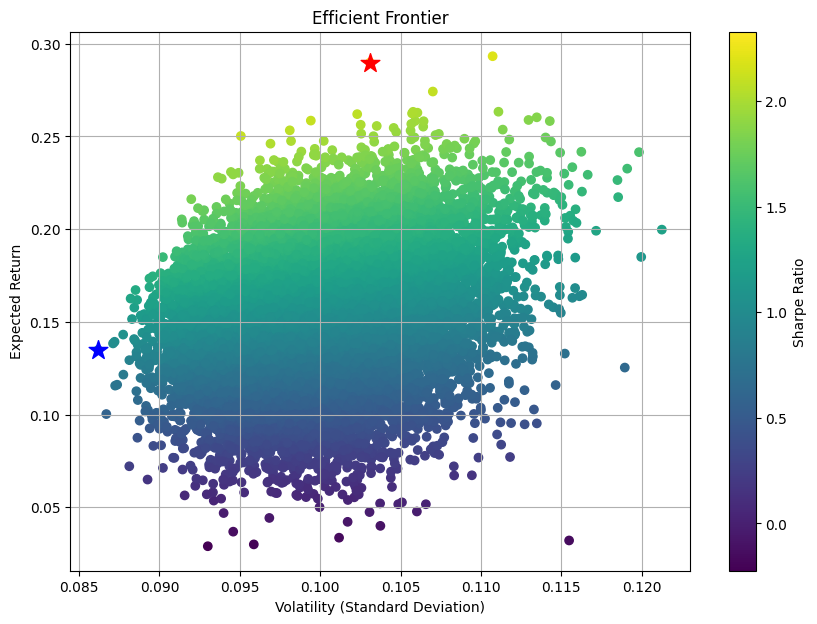

In [50]:
import matplotlib.pyplot as plt

# Plotting the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(volatility_array, return_array, c=sharpe_ratio_array, cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')

# Labeling the axes
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')

# Adding grid for better readability
plt.grid(True)

# Optionally, highlight the portfolio with the highest Sharpe ratio
max_sharpe_idx = sharpe_ratio_array.argmax()
plt.scatter(volatility_array[max_sharpe_idx], return_array[max_sharpe_idx], color='r', marker='*', s=200)

# Optionally, highlight the portfolio with the minimum volatility
min_volatility_idx = volatility_array.argmin()
plt.scatter(volatility_array[min_volatility_idx], return_array[min_volatility_idx], color='b', marker='*', s=200)

plt.show()


#### Optimizing Portfolio Optimization Using SciPy

#### The Monte Carlo Analysis did good but lets try and use an optimization library to see what the most optimal weight allocations look like

##### Source code: https://github.com/adam5644/Quantitative_Trading_and_Research/blob/master/Optimize%20Portfolio%20Sharpe.ipynb



### add modifications

#### Minimizing Volatiltiy
##### Model is set up to minimize target varriables. Method used is 'trust-constr' but other methods like SLSQP may also be used. SciPy's Documentation can be found here:https://docs.scipy.org/doc/scipy/tutorial/optimize.html

##### Bound contraint is set so that every stock needs at minimum to have .02% of the total portfolio to be invested in them, feel free to adjust based on your preferences

In [51]:
import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize


bounds = Bounds(.02,1) # all weights between .02 and 1
linear_constraint = LinearConstraint(np.ones(len(symbols_lst)), 1,1) # weights are equal to 1
mean_returns = returns_df.mean()*252

weights = np.ones(len(symbols_lst))
x0 = [0.1]*len(symbols_lst) # initial guess of respective weights

portfstrderr = lambda w: np.sqrt(np.dot(w, np.dot(w,cov_matrix))*252)

# Set options for the optimizer to improve results
options = {
    'disp': True,  # Display convergence messages
    'maxiter': 11000,  # Increase maximum number of iterations
    'gtol': 1e-9  # Set gradient tolerance (convergence criteria)
}

res1 = minimize(portfstrderr, x0, method='trust-constr', constraints=linear_constraint, bounds=bounds,options=options)

`gtol` termination condition is satisfied.
Number of iterations: 55, function evaluations: 1395, CG iterations: 159, optimality: 5.52e-10, constraint violation: 0.00e+00, execution time: 0.25 s.


### Results - Minimizing Volatlity

In [52]:
def ret(mean_returns,weights):
    return mean_returns.dot(weights)

def vol(weights,cov_matrix):
    return np.sqrt(np.dot(weights, np.dot(weights,cov_matrix))*252)

def sharpe(ret,vol,rf):
    return (ret-rf)/vol

w_min = res1.x
ret1 = ret(mean_returns,w_min)
vol1 = vol(w_min,cov_matrix)
sharpe1 = sharpe(ret1, vol1,rf) #adding risk free rate for more accurate depiction of sharpe ratio
print('return = ', round(ret1,4))
print('vol = ', round(vol1,4))
print('sharpe ratio = ', round(sharpe1,4))
print('---'*20)
#rounding the weights
rounded_weights = [round(w,2) for w in w_min]
print('weights = ', (rounded_weights))

return =  0.1338
vol =  0.0835
sharpe ratio =  1.0061
------------------------------------------------------------
weights =  [0.02, 0.02, 0.02, 0.02, 0.03, 0.08, 0.02, 0.06, 0.02, 0.08, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.13, 0.06, 0.02, 0.07, 0.02, 0.02, 0.02, 0.02, 0.02, 0.05]


As we can see, using the SciPy's optimization we were able to achieve a lower volatility and a higher sharpe ratio when compared to the above monte carlo simulation.

### Maximizing Sharpe Ratio

In [53]:
invSharpe = lambda w: np.sqrt(np.dot(w, np.dot(w,cov_matrix))*252)   /    mean_returns.dot(w)-rf
res2 = minimize(invSharpe, x0, method='trust-constr', constraints=linear_constraint, bounds=bounds)

w_Sharpe = res2.x
ret2 = ret(mean_returns,w_Sharpe)
vol2 = vol(w_Sharpe,cov_matrix)
sharpe2 = sharpe(ret2, vol2,rf)
print('return = ', round(ret2,2))
print('vol = ', round(vol2,2))
print('sharpe ratio = ', round(sharpe2,2))

print('---'*20)
#rounding the weights
rounded_weights = [round(w,2) for w in w_min]
print('weights = ', (rounded_weights))


return =  0.36
vol =  0.12
sharpe ratio =  2.62
------------------------------------------------------------
weights =  [0.02, 0.02, 0.02, 0.02, 0.03, 0.08, 0.02, 0.06, 0.02, 0.08, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.13, 0.06, 0.02, 0.07, 0.02, 0.02, 0.02, 0.02, 0.02, 0.05]


### Correlation Against Benchmarks
##### The current benchmarks uses are 'BDN','DIA','GLD','QQQ','SPY','USO','SSO', these all can be swapped out for other benchmarks of your choice

In [54]:
benchmarks_lst=['BDN','DIA','GLD','QQQ','SPY','USO','SSO']

benchmark_df2_data=yf.download(benchmarks_lst, period='1y')['Adj Close']

#calculating returns
benchmark_returns=benchmark_df2_data.pct_change().dropna()

#log returns
bench_mark_log_returns = np.log(1 + benchmark_returns)


benchmark_df2=pd.DataFrame(bench_mark_log_returns)

[*********************100%%**********************]  7 of 7 completed


In [55]:
ticker_lst=portfolio_metrics['Ticker'].to_list()
weight_lst=portfolio_metrics['Portfolio Weight %'].to_list()
weights_dict = dict(zip(ticker_lst, weight_lst))


charts_df=returns_df.copy()
#calculating daily weighted log returns
charts_df['Weighted Returns'] = charts_df.dot(pd.Series(weights_dict))

#cleaning datetime index
charts_df.index = charts_df.index.date
benchmark_df2.index = benchmark_df2.index.date

In [56]:
correlation_df = pd.concat([charts_df['Weighted Returns'], benchmark_df2], axis=1).dropna()

#correlations with benchmarks
correlation_df['SPY Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['SPY'])
correlation_df['QQQ Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['QQQ'])
correlation_df['DIA Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['DIA'])
correlation_df['USO Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['USO'])
correlation_df['GLD Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['GLD'])
correlation_df['BDN Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['BDN'])
correlation_df['SSO Correlation'] = correlation_df['Weighted Returns'].rolling(window=30).corr(benchmark_df2['SSO'])


Text(0.5, 1.0, 'Rolling 30-Day Correlation with Benchmark')

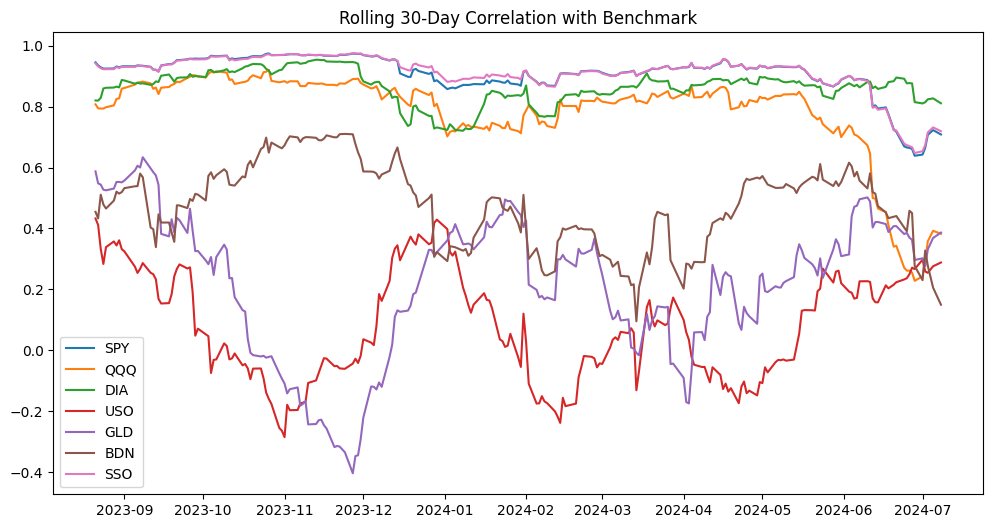

In [57]:
#plotting correlations
plt.figure(figsize=(12, 6))
plt.plot(correlation_df['SPY Correlation'], label='SPY')
plt.plot(correlation_df['QQQ Correlation'], label='QQQ')
plt.plot(correlation_df['DIA Correlation'], label='DIA')
plt.plot(correlation_df['USO Correlation'], label='USO')
plt.plot(correlation_df['GLD Correlation'], label='GLD')
plt.plot(correlation_df['BDN Correlation'], label='BDN')
plt.plot(correlation_df['SSO Correlation'], label='SSO')
plt.legend()
plt.title('Rolling 30-Day Correlation with Benchmark')

#### Computing returns again for the cumulative returns chart

In [58]:
#calculating portfolio log returns without annualization or expected returns

portfolio_log_returns = pd.DataFrame()

# Loop through each stock in the portfolio
for index, row in portfolio_metrics.iterrows():
    ticker = row['Ticker']
    weight = row['Portfolio Weight %']
    
    # Retrieve the stock's historical data
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period="1y")
    
    # Calculate daily log returns
    daily_returns = stock_hist['Close'].pct_change().dropna()
    stock_log_returns = np.log(1 + daily_returns)
    
    # Add weighted log returns to the portfolio log returns DataFrame
    portfolio_log_returns[ticker] = stock_log_returns * weight
    
    
    
#making a column for the portfolio log returns
portfolio_log_returns['Portfolio_Log_Returns'] = portfolio_log_returns.sum(axis=1)
    

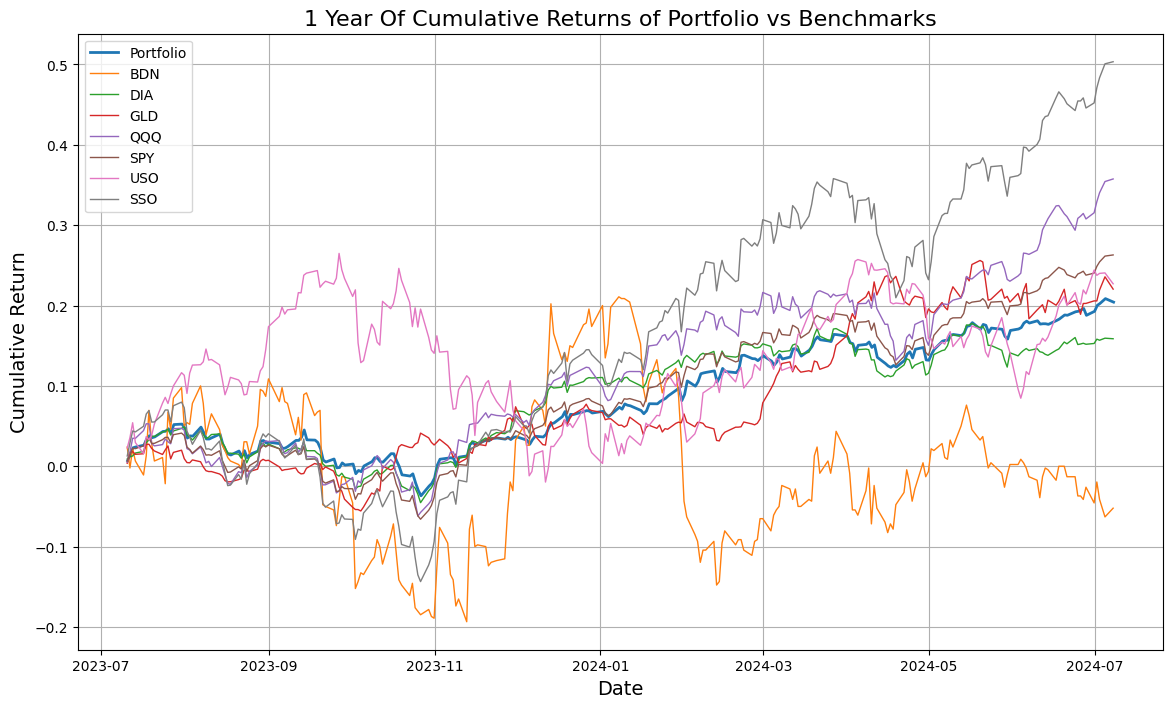

In [59]:
###plotting cumulative returns vs benchmark
# Calculate cumulative log returns
cumulative_log_benchmark_returns = bench_mark_log_returns.cumsum()
cumulative_log_portfolio_returns = portfolio_log_returns['Portfolio_Log_Returns'].cumsum()

#converting cumulative log returns to returns
cumulative_benchmark_returns = np.exp(cumulative_log_benchmark_returns)-1
cumulative_portfolio_returns = np.exp(cumulative_log_portfolio_returns)-1

# Plot cumulative returns
plt.figure(figsize=(14, 8))

# Plot portfolio cumulative returns
plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Portfolio', linewidth=2)

# Plot benchmarks cumulative returns
for ticker in benchmarks_lst:
    plt.plot(cumulative_benchmark_returns.index, cumulative_benchmark_returns[ticker], label=ticker, linewidth=1)

# Adding titles and labels
plt.title('1 Year Of Cumulative Returns of Portfolio vs Benchmarks', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Scenario Analysis

### Investors may have differnet out looks on the economy. During different economic conditions certain factors change. For the below analysis I looked at risk free rate and the market as a whole. Afterwords with these metrics I will simulate the last years returns had these different market conditions occured.

### Examining Recession Dates with the 1987 crash, dot com bubble, and the great recession

In [60]:
rf_data=fred.get_series('DGS1')
rf_data=pd.DataFrame(rf_data)
rf_data.index=pd.to_datetime(rf_data.index)
rf_data.rename(columns={0:'Risk Free Rate'}, inplace=True)
#gathering data past 1980 and before 2010
rf_data_subset=rf_data.loc['1985-01-01':'2010-01-01']


In [61]:
from datetime import datetime

# Define recession dates with datetime objects directly


#below are the ranges for the recession dates
recession_dates = [
    (datetime(1987, 10, 19), datetime(1988, 1, 1)),  # 1987 crash
    (datetime(2000, 3, 10), datetime(2001, 11, 1)),   # dot-com bubble
    (datetime(2007, 12, 1), datetime(2009, 6, 1)),    # great recession

]


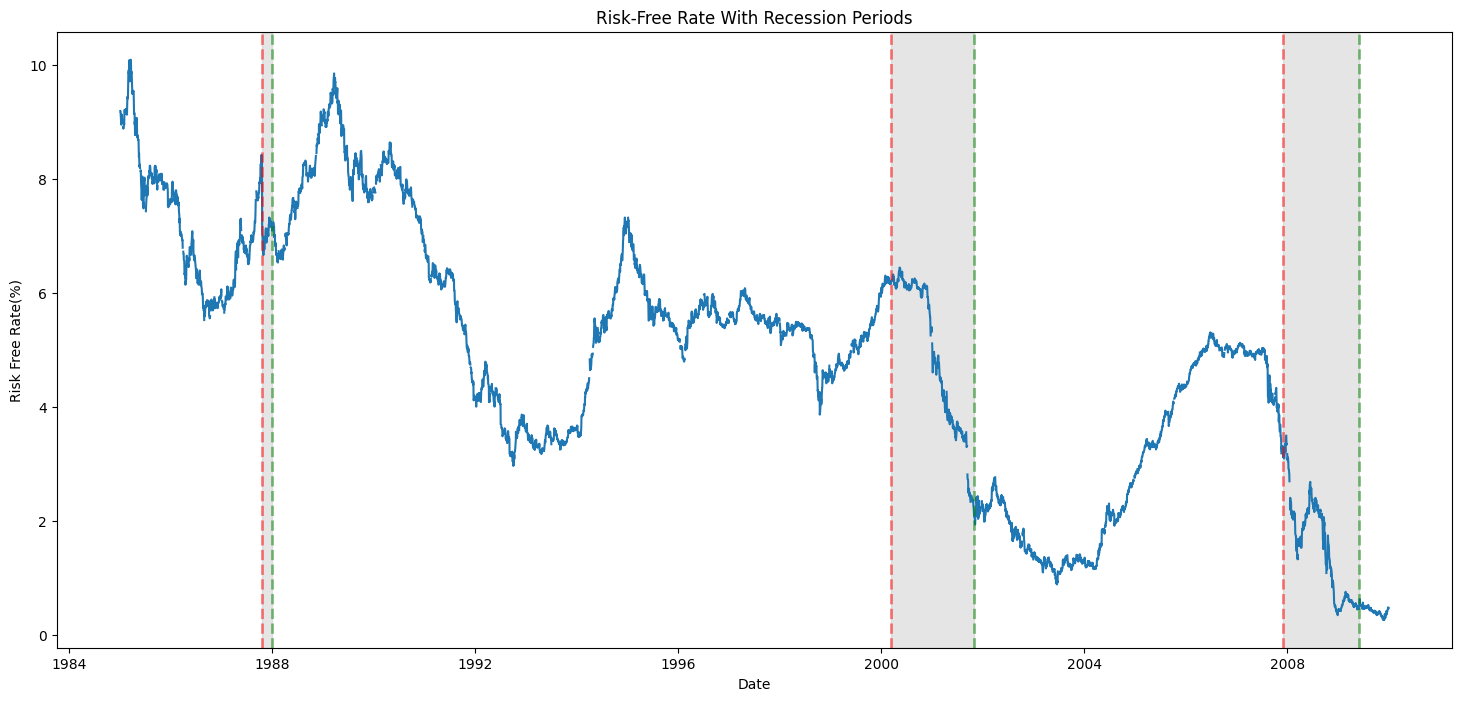

In [62]:
plt.figure(figsize=(18, 8))
plt.plot(rf_data_subset)
plt.title('Risk-Free Rate With Recession Periods')
plt.xlabel('Date')
plt.ylabel('Risk Free Rate(%)')
# Add vertical lines for recession periods

for start, end in recession_dates:
    plt.axvline(x=start, color='r', linestyle='--', lw=2, label='Recession Start',alpha=0.5)
    plt.axvline(x=end, color='g', linestyle='--', lw=2, label='Recession End',alpha=0.5)
    plt.axvspan(start, end, color='gray', alpha=0.2)  # Add gray shaded region
    
plt.show()


In [63]:
'''Calculating the risk-free rate before the recession periods to understand the impact of the recession on the risk-free rate'''
recession1_data_before=recession_dates[0][0] - pd.DateOffset(months=2) 
recession2_data_before=recession_dates[1][0] - pd.DateOffset(months=2)
recession3_data_before=recession_dates[2][0] - pd.DateOffset(months=2)

rf_data_before_recession1=rf_data.loc[recession1_data_before:recession_dates[0][0]]
rf_data_before_recession2=rf_data.loc[recession2_data_before:recession_dates[1][0]]
rf_data_before_recession3=rf_data.loc[recession3_data_before:recession_dates[2][0]]


#exculding day of the reccesion
rf_data_before_recession1=float(rf_data_before_recession1[:-1].mean())
rf_data_before_recession2=float(rf_data_before_recession2[:-1].mean())
rf_data_before_recession3=float(rf_data_before_recession3[:-1].mean())




In [64]:
'''calculating the average risk free rate during the recession'''

rf_recession1=float(rf_data.loc[recession_dates[0][0]:recession_dates[0][1]].mean())
rf_recession2=float(rf_data.loc[recession_dates[1][0]:recession_dates[1][1]].mean())
rf_recession3=float(rf_data.loc[recession_dates[2][0]:recession_dates[2][1]].mean())


### Risk Free Rate Before and After the 1987 Crash

In [65]:
print(f'The average risk free rate before the 1987 recession was {round(rf_data_before_recession1,2)}')
print(f'The average risk free rate during the 1987 recession was {round(rf_recession1,2)}')
diff_recession1= rf_recession1 - rf_data_before_recession1
diff_recession1=round(diff_recession1,2)

print('The difference in the risk free rate is:', diff_recession1)

The average risk free rate before the 1987 recession was 7.68
The average risk free rate during the 1987 recession was 7.06
The difference in the risk free rate is: -0.62


### Risk Free Rate Before and After the Dot Com Bubble Crash (2000's)

In [66]:
print(f'The average risk free rate before the Dot Com Bubble Crash recession was {round(rf_data_before_recession2,2)}')
print(f'The average risk free rate during the Dot Com Bubble Crash recession was {round(rf_recession2,2)}')
diff_recession2= rf_recession2 - rf_data_before_recession2
diff_recession2=round(diff_recession2,2)

print('The difference in the risk free rate is:', diff_recession2)

The average risk free rate before the Dot Com Bubble Crash recession was 6.19
The average risk free rate during the Dot Com Bubble Crash recession was 4.9
The difference in the risk free rate is: -1.29


### Risk Free Rate Before and After the Great Recession (2008)

In [67]:
print(f'The average risk free rate before the Great Recession was {round(rf_data_before_recession3,2)}')
print(f'The average risk free rate during the Great Recession was {round(rf_recession3,2)}')
diff_recession3= rf_recession3 - rf_data_before_recession3
diff_recession3=round(diff_recession3,2)

print('The difference in the risk free rate is:', diff_recession3)


The average risk free rate before the Great Recession was 3.83
The average risk free rate during the Great Recession was 1.55
The difference in the risk free rate is: -2.27


### We can conclude that the risk free rate *drops* during recessions by around 1.4%

In [68]:
severe_rf_recession=(diff_recession1+diff_recession2+diff_recession3)/3
rf_recession=round(severe_rf_recession,2)/100
rf_recession

-0.0139

### Examining Risk Free Rate During Economic Booms

In [69]:
economic_booms = [

    (datetime(1991, 3, 1), datetime(2001, 3, 31)),   # Longest Peace-Time Expansion
    (datetime(2001, 11, 1), datetime(2007, 12, 31)), # Early 2000s Expansion
    (datetime(2009, 6, 1), datetime(2020, 2, 29))    # Post-Great Recession Recovery
]


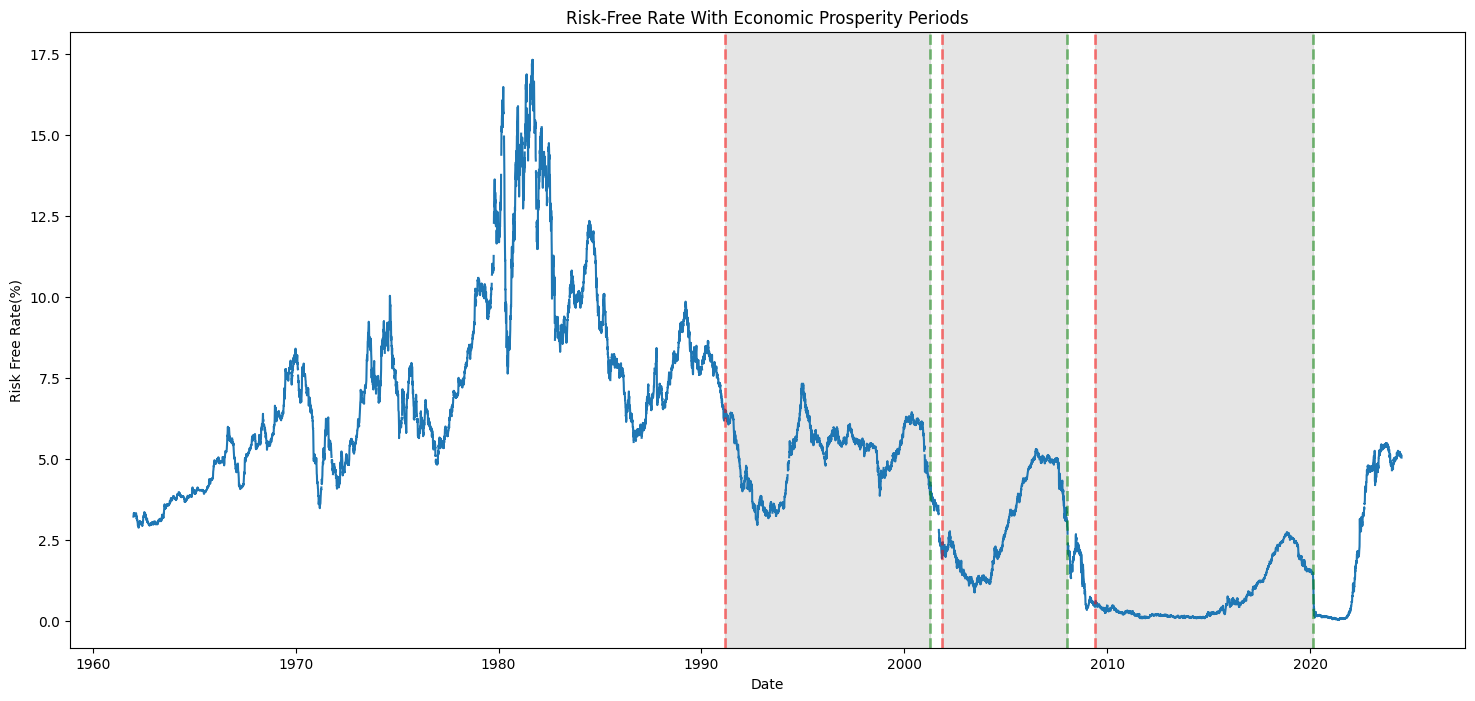

In [70]:
plt.figure(figsize=(18, 8))
plt.plot(rf_data)
plt.title('Risk-Free Rate With Economic Prosperity Periods')
plt.xlabel('Date')
plt.ylabel('Risk Free Rate(%)')
# Add vertical lines for recession periods

for start, end in economic_booms:
    plt.axvline(x=start, color='r', linestyle='--', lw=2, label='Boom Start',alpha=0.5)
    plt.axvline(x=end, color='g', linestyle='--', lw=2, label='Boom End',alpha=0.5)
    plt.axvspan(start, end, color='gray', alpha=0.2)  # Add gray shaded region
    
plt.show()

In [71]:
#since the time period is much longer for economic booms, we will calculate the average risk free rate only during the economic booms

'''calculating the average risk free rate during the boom'''

rf_boom1=float(rf_data.loc[economic_booms[0][0]:economic_booms[0][1]].mean())
rf_boom2=float(rf_data.loc[economic_booms[1][0]:economic_booms[1][1]].mean())
rf_boom3=float(rf_data.loc[economic_booms[2][0]:economic_booms[2][1]].mean())


### Average Risk Free Rate during the 3 economic booms

In [72]:
print(f'The average risk free rate during the Longest Peace-Time Expansion was {round(rf_boom1,2)}')
print(f'The average risk free rate during the Early 2000s Expansion was {round(rf_boom2,2)}')
print(f'The average risk free rate during the Post-Great Recession Recovery was {round(rf_boom3,2)}')
large_rf_expansion=(rf_boom1+rf_boom2+rf_boom3)/3
rf_boom=round(large_rf_expansion,2)



print('The average risk free rate during the economic booms is:',(rf_boom))

rf_boom=rf_boom/100

The average risk free rate during the Longest Peace-Time Expansion was 5.15
The average risk free rate during the Early 2000s Expansion was 3.02
The average risk free rate during the Post-Great Recession Recovery was 0.74
The average risk free rate during the economic booms is: 2.97


#### Market - finding out how much the market falls or rises during different economic conditions

In [73]:
#market
market=yf.download('^GSPC',period='50y')
market_df=market['Adj Close']

[*********************100%%**********************]  1 of 1 completed


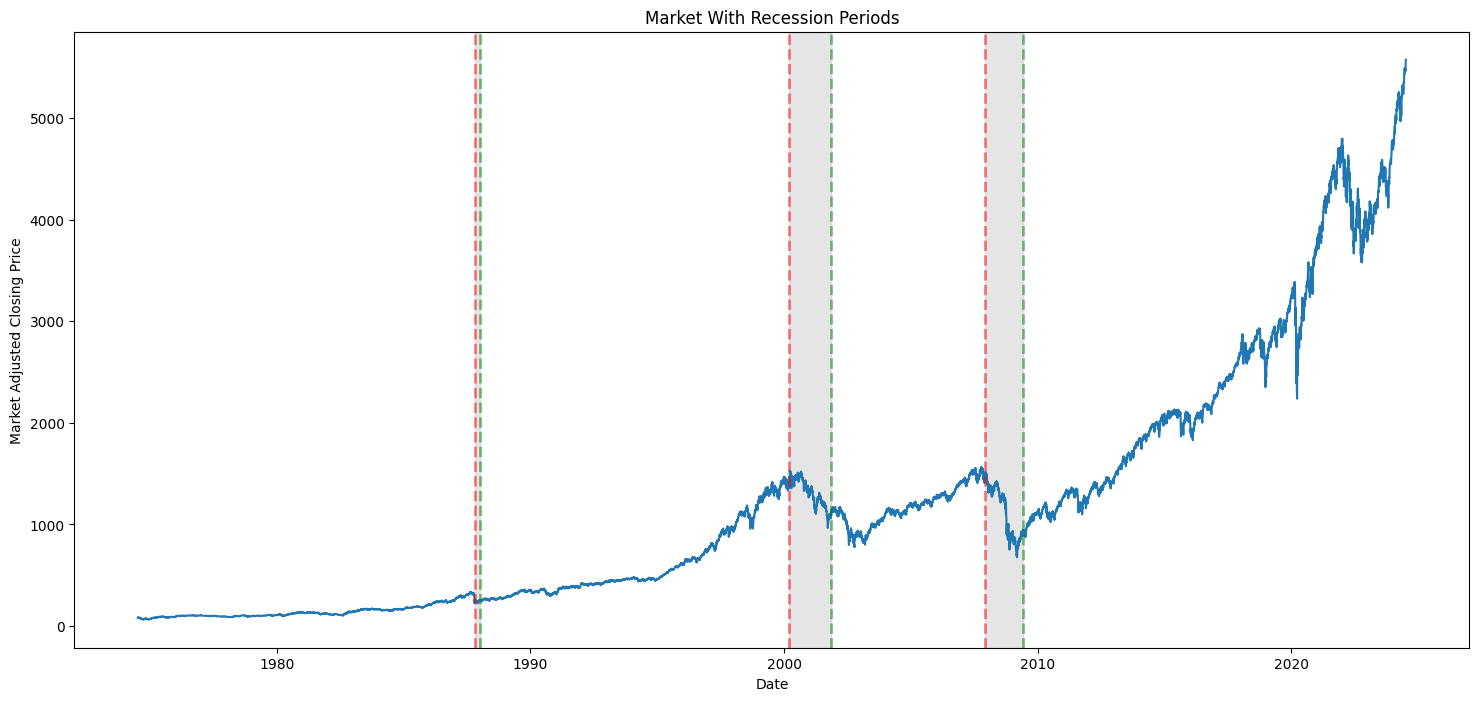

In [74]:
plt.figure(figsize=(18, 8))
plt.plot(market_df)
plt.title('Market With Recession Periods')
plt.xlabel('Date')
plt.ylabel('Market Adjusted Closing Price')
# Add vertical lines for recession periods

for start, end in recession_dates:
    plt.axvline(x=start, color='r', linestyle='--', lw=2, label='Recession Start',alpha=0.5)
    plt.axvline(x=end, color='g', linestyle='--', lw=2, label='Recession End',alpha=0.5)
    plt.axvspan(start, end, color='gray', alpha=0.2)  # Add gray shaded region
    
plt.show()

In [75]:
#calculating the average market returns during the recession periods
market_recession1=market_df.loc[recession_dates[0][0]:recession_dates[0][1]].mean()
market_recession2=market_df.loc[recession_dates[1][0]:recession_dates[1][1]].mean()
market_recession3=market_df.loc[recession_dates[2][0]:recession_dates[2][1]].mean()


market_data_before_recession1=market_df.loc[recession1_data_before:recession_dates[0][0]]
market_data_before_recession2=market_df.loc[recession2_data_before:recession_dates[1][0]]
market_data_before_recession3=market_df.loc[recession3_data_before:recession_dates[2][0]]


#exculding day of the reccesion
market_data_before_recession1=float(market_data_before_recession1[:-1].mean())
market_data_before_recession2=float(market_data_before_recession2[:-1].mean())
market_data_before_recession3=float(market_data_before_recession3[:-1].mean())


In [76]:
'''Calculating the market returns before the recession periods to understand the impact of the recession on the market returns'''
percentage_drop1=(market_data_before_recession1- market_recession1)/ (market_data_before_recession1)
percentage_drop2=(market_data_before_recession2- market_recession2)/ (market_data_before_recession2)
percentage_drop3=(market_data_before_recession3- market_recession3)/ (market_data_before_recession3)


#### Average Market Drop during the 1987 Crash

In [77]:
percentage_drop1 # meaning the market dropped by 24 %%!

0.24237996840869996

#### Average Market Drop during the Dot Com Bubble Crash

In [78]:
percentage_drop2

0.059790245580509244

#### Average Market Drop during the Great Recession

In [79]:
percentage_drop3

0.24953682637379768

In [80]:
#calculating average recession drop 
market_recession=((percentage_drop1+percentage_drop2+percentage_drop3)/3) *-1 #negative because it is a drop

### Lastly we will calculate the same for when the market goes up to understand market upward trends


In [81]:
#economic booms
market_boom1=(market_df.loc[economic_booms[0][0]:economic_booms[0][1]])
market_boom2=(market_df.loc[economic_booms[1][0]:economic_booms[1][1]])
market_boom3=(market_df.loc[economic_booms[2][0]:economic_booms[2][1]])

In [82]:
#gathering 1 month of data during the first 3 years of the economic boom to establish a starting point
boom_start1=market_boom1[:1095].mean()
boom_start2=market_boom2[:1095].mean()
boom_start3=market_boom3[:1095].mean()

#gathering 1 month of data during the 3 years of the economic boom to establish an ending point
boom_end1=market_boom1[-1095:].mean()
boom_end2=market_boom2[-1095:].mean()
boom_end3=market_boom3[-1095:].mean()

#calculating the percentage increase in the market during the economic booms
boom_percentage1=(boom_end1-boom_start1)/boom_start1
boom_percentage2=(boom_end2-boom_start2)/boom_start2
boom_percentage3=(boom_end3-boom_start3)/boom_start3



### Average market increase during economic booms

In [83]:
#calculating the average market increase during the economic booms
market_boom=(boom_percentage1+boom_percentage2+boom_percentage3)/3
market_boom

0.9426669947495382

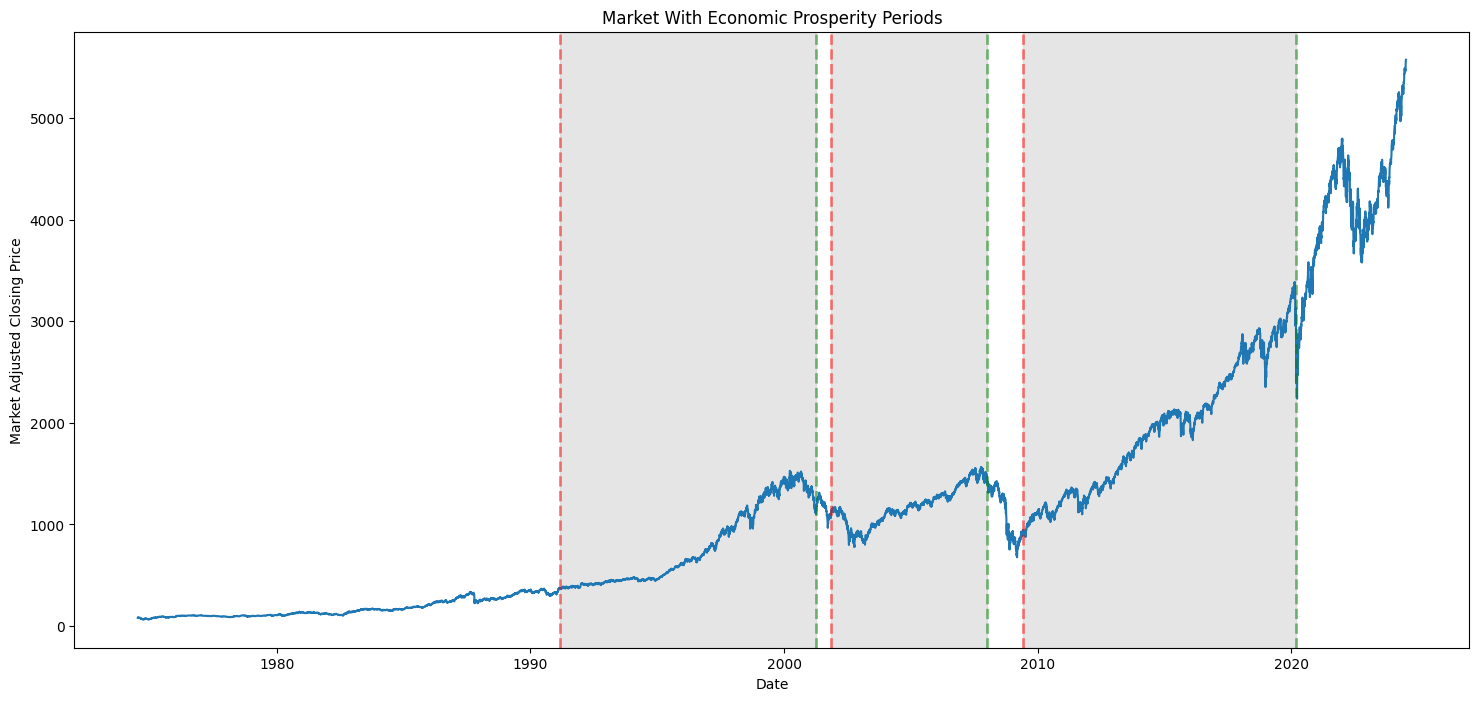

In [84]:
plt.figure(figsize=(18, 8))
plt.plot(market_df)
plt.title('Market With Economic Prosperity Periods')
plt.xlabel('Date')
plt.ylabel('Market Adjusted Closing Price')
# Add vertical lines for recession periods

for start, end in economic_booms:
    plt.axvline(x=start, color='r', linestyle='--', lw=2, label='Boom Start',alpha=0.5)
    plt.axvline(x=end, color='g', linestyle='--', lw=2, label='Boom End',alpha=0.5)
    plt.axvspan(start, end, color='gray', alpha=0.2)  # Add gray shaded region
    
plt.show()

#### Scenario Analysis

### I constructed a Scenario analysis below for 4 different scenarios: mild recession, severe recession, mild boom, and significant boom. This will allow you to estimate how your portfolio may perform given your outlook on the economy

In [85]:
#show metrcis for each scenario
#1. Expected return
#2. Expected volatility
#3. Expected Sharpe Ratio


def mild_recession(portfolio_metrics):
    #risk free rate drops
    mild_rf=rf+(rf_recession/2) #half of the recession rate for a mild recession
    
    market_drop_multiplier=market_recession/2
    
    #adjusting the expected return based on the market drop multiplier
    for i in portfolio_metrics:
        adjusted_expected_return=(portfolio_metrics['Stock Return'] + (portfolio_metrics['Beta'] * market_drop_multiplier)) * portfolio_metrics['Portfolio Weight %'] 
        adjusted_expected_return=adjusted_expected_return.sum()
        #calculate the weighted adjusted volatility
        adjusted_cov_matrix = annualized_cov_matrix * (1 + market_drop_multiplier ** 2)
        function_portfolio_variance = np.dot(portfolio_weights.T, np.dot(adjusted_cov_matrix, portfolio_weights))
        weighted_adjusted_volatility = np.sqrt(function_portfolio_variance)
        
    #sharpe ratio
    sharpe_ratio=(adjusted_expected_return - mild_rf) / weighted_adjusted_volatility
    
    print(f"Adjusted Expected Return: {round(adjusted_expected_return,2)}")
    print(f"Weighted Adjusted Volatility: {round(weighted_adjusted_volatility,2)}")
    print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        
    return adjusted_expected_return,weighted_adjusted_volatility, sharpe_ratio
    
 
  

def severe_recession(portfolio):
      
        #risk free rate drops
    mild_rf=rf+(rf_recession) #full recession rate for a severe recession
    
    market_drop_multiplier=market_recession #full recession rate for a severe recession
    
    #adjusting the expected return based on the market drop multiplier
    for i in portfolio_metrics:
        adjusted_expected_return=(portfolio_metrics['Stock Return'] + (portfolio_metrics['Beta'] * market_drop_multiplier)) * portfolio_metrics['Portfolio Weight %'] 
        adjusted_expected_return=adjusted_expected_return.sum()
        #calculate the weighted adjusted volatility
        adjusted_cov_matrix = annualized_cov_matrix * (1 + market_drop_multiplier ** 2)
        function_portfolio_variance = np.dot(portfolio_weights.T, np.dot(adjusted_cov_matrix, portfolio_weights))
        weighted_adjusted_volatility = np.sqrt(function_portfolio_variance)
        
    #sharpe ratio
    sharpe_ratio=(adjusted_expected_return - mild_rf) / weighted_adjusted_volatility
    
    print(f"Adjusted Expected Return: {round(adjusted_expected_return,2)}")
    print(f"Weighted Adjusted Volatility: {round(weighted_adjusted_volatility,2)}")
    print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        
    return adjusted_expected_return,weighted_adjusted_volatility, sharpe_ratio
    
    
def mild_boom(portfolio):
    mild_boom_rf=rf_boom #not adjusting the risk free rate for a mild boom or a significant boom
    market_increase_multiplier=market_boom/2
    
    for i in portfolio_metrics:
        adjusted_expected_return=(portfolio_metrics['Stock Return'] + (portfolio_metrics['Beta'] * market_increase_multiplier)) * portfolio_metrics['Portfolio Weight %'] 
        adjusted_expected_return=adjusted_expected_return.sum()
        #calculate the weighted adjusted volatility
        adjusted_cov_matrix = annualized_cov_matrix * (1 + market_increase_multiplier ** 2)
        function_portfolio_variance = np.dot(portfolio_weights.T, np.dot(adjusted_cov_matrix, portfolio_weights))
        weighted_adjusted_volatility = np.sqrt(function_portfolio_variance)
        
        #sharpe ratio
        sharpe_ratio=(adjusted_expected_return - mild_boom_rf) / weighted_adjusted_volatility
        
    print(f"Adjusted Expected Return: {round(adjusted_expected_return,2)}")
    print(f"Weighted Adjusted Volatility: {round(weighted_adjusted_volatility,2)}")
    print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        
    return adjusted_expected_return,weighted_adjusted_volatility, sharpe_ratio
        




    
def significant_boom(portfolio):
    significant_boom_rf=rf_boom #not adjusting the risk free rate for a mild boom or a significant boom
    market_increase_multiplier=market_boom #full boom rate for a significant boom
    
    for i in portfolio_metrics:
        adjusted_expected_return=(portfolio_metrics['Stock Return'] + (portfolio_metrics['Beta'] * market_increase_multiplier)) * portfolio_metrics['Portfolio Weight %'] 
        adjusted_expected_return=adjusted_expected_return.sum()
        
        #calculate the weighted adjusted volatility

        
        adjusted_cov_matrix = annualized_cov_matrix * (1 + market_increase_multiplier ** 2)
        function_portfolio_variance = np.dot(portfolio_weights.T, np.dot(adjusted_cov_matrix, portfolio_weights))
        weighted_adjusted_volatility = np.sqrt(function_portfolio_variance)
        
        
        #sharpe ratio
        sharpe_ratio=(adjusted_expected_return - significant_boom_rf) / weighted_adjusted_volatility
        
    print(f"Adjusted Expected Return: {round(adjusted_expected_return,2)}")
    print(f"Weighted Adjusted Volatility: {round(weighted_adjusted_volatility,2)}")
    print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        
    return adjusted_expected_return,weighted_adjusted_volatility, sharpe_ratio
      

In [86]:
mild_recession(portfolio_metrics) 

Adjusted Expected Return: 0.11
Weighted Adjusted Volatility: 0.09
Sharpe Ratio: 0.74


(0.10662739481732053, 0.0861791075864153, 0.7400563385199637)

In [87]:
severe_recession(portfolio_metrics)

Adjusted Expected Return: 0.03
Weighted Adjusted Volatility: 0.09
Sharpe Ratio: -0.11


(0.025937481629028977, 0.08725618219882557, -0.11417550160824153)

In [88]:
mild_boom(portfolio_metrics)

Adjusted Expected Return: 0.6
Weighted Adjusted Volatility: 0.09
Sharpe Ratio: 6.02


(0.6009265919568932, 0.09487175148548137, 6.021039803869443)

In [89]:
significant_boom(portfolio_metrics)

Adjusted Expected Return: 1.01
Weighted Adjusted Volatility: 0.12
Sharpe Ratio: 8.35


(1.0145358759081744, 0.11793593139515458, 8.350600739382777)

### If you want to use your own assumption instead of the ones provided use this code below: only need to edit the first two varribles specifiying risk free rate and market increase/drop

In [90]:
#varriables to edit
user_market_condition=-.20
user_risk_free_rate=.03


def user_economic_scenario(portfolio_metrics):
    
    for i in portfolio_metrics:
        
        #calculate the adjusted expected return
        adjusted_expected_return=(portfolio_metrics['Stock Return'] + (portfolio_metrics['Beta'] * user_market_condition)) * portfolio_metrics['Portfolio Weight %'] 
        adjusted_expected_return=adjusted_expected_return.sum()
        
        
        
        
        #calculate the weighted adjusted volatility

        
        adjusted_cov_matrix = annualized_cov_matrix * (1 + user_market_condition ** 2)
        function_portfolio_variance = np.dot(portfolio_weights.T, np.dot(adjusted_cov_matrix, portfolio_weights))
        weighted_adjusted_volatility = np.sqrt(function_portfolio_variance)
        
        
        #sharpe ratio
        sharpe_ratio=(adjusted_expected_return - user_risk_free_rate) / weighted_adjusted_volatility
    
    
    print('User Assumptions:')
    print(f"Market Condition: {user_market_condition}")
    print(f"Risk Free Rate: {user_risk_free_rate}")
    print('---'*20)
    print(f"Adjusted Expected Return: {round(adjusted_expected_return,2)}")
    print(f"Weighted Adjusted Volatility: {round(weighted_adjusted_volatility,2)}")
    print(f"Sharpe Ratio: {round(sharpe_ratio,2)}")
        
    return adjusted_expected_return,weighted_adjusted_volatility, sharpe_ratio
user_economic_scenario(portfolio_metrics)
    

User Assumptions:
Market Condition: -0.2
Risk Free Rate: 0.03
------------------------------------------------------------
Adjusted Expected Return: 0.01
Weighted Adjusted Volatility: 0.09
Sharpe Ratio: -0.21


(0.011811308005612094, 0.08751659180954412, -0.20783135652689275)